In [1]:
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax
from jax import config
config.update("jax_enable_x64", True)


from simphony.time_domain import TimeSim
from simphony.time_domain.utils import gaussian_pulse, smooth_rectangular_pulse 
from simphony.libraries import siepic, ideal
from simphony.time_domain.ideal import Modulator,MMI

import json
from tqdm.auto import tqdm
from scipy.integrate import solve_ivp
from scipy.interpolate import CubicSpline
from scipy.interpolate import interp1d



/workspaces/time_domain_work/.venv/lib/python3.12/site-packages/sax/backends/__init__.py:58: UserWarning: klujax not found. Please install klujax for better performance during circuit evaluation!
  warnings.warn(
/workspaces/time_domain_work/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
netlist = {
    "instances":{
        "wg1":"waveguide",
        "wg2":"waveguide",
        "wg3":"waveguide",
        "wg4":"waveguide",
        "y1":"y_branch",
        "y2":"y_branch",
        "y3":"y_branch",
        "y4":"y_branch",
        "y5":"y_branch",
        "y6":"y_branch",
        "pm1":"phase_modulator1",
        "pm2":"phase_modulator2",
        "pm3":"phase_modulator3",
        "pm4":"phase_modulator4",
        "pm5":"phase_modulator5",
        "pm6":"phase_modulator6",
    },
    "connections":{
        "y1,port_2":"y2,port_1",
        "y1,port_3":"y3,port_1",

        "wg1,o0":"y2,port_2",
        "wg2,o0":"y2,port_3",

        "wg3,o0":"y3,port_2",
        "wg4,o0":"y3,port_3",

        "wg1,o1":"pm1,o0",
        "wg2,o1":"pm2,o0",
        "wg3,o1":"pm3,o0",
        "wg4,o1":"pm4,o0",

        "y4,port_2":"pm1,o1",
        "y4,port_3":"pm2,o1",
        "y5,port_2":"pm3,o1",
        "y5,port_3":"pm4,o1",

        "y6,port_2":"y4,port_1",

        "y5,port_1":"pm5,o0",
        "pm5,o1":"y6,port_3",

        "y6,port_1":"pm6,o0",
    },
    "ports":{
        "o0":"y1,port_1",
        "o1":"pm6,o1",
    }

}
T = 100e-11
dt = 1e-14
t = jnp.arange(0,T,dt)
num_measurements = 200
wvl = np.linspace(1.5, 1.6, num_measurements)
options = {
    'wl': wvl,
    'wg1': {'length': 10.0},
    'wg2': {'length': 10.0},
    'wg3': {'length': 10.0},
    'wg4': {'length': 10.0},
}
def generate_random_phases(
    key,
    t: jnp.ndarray,
    phases: jnp.ndarray,
    warmup_time: float,
    switch_time: float
) -> jnp.ndarray:
    """
    Generate a piecewise‐constant phase array over time t.
    
    Args:
      key:        JAX PRNGKey for randomness.
      t:          1D time‐axis array (shape [N]).
      phases:     1D array of phase values to choose from (shape [4]).
      warmup_time: float, total time to hold the first random phase.
      switch_time: float, time interval between subsequent random switches.
    
    Returns:
      1D jnp.ndarray of shape [N], giving the phase at each t[i].
    """
    dt = t[1] - t[0]
    N = t.shape[0]
    # Number of samples for warm-up and each switch block
    warmup_steps = int(jnp.round(warmup_time / dt))
    switch_steps = int(jnp.round(switch_time / dt))
    
    # --- Pick initial phase for warm-up ---
    key, subkey = jax.random.split(key)
    init_phase = jax.random.choice(subkey, phases)
    
    # --- Determine how many switch‐blocks fit in the remainder ---
    remaining = N - warmup_steps
    num_blocks = int(jnp.ceil(remaining / switch_steps))
    
    # --- Sample one random phase per block ---
    key, subkey = jax.random.split(key)
    block_phases = jax.random.choice(subkey, phases, shape=(num_blocks,))
    
    # --- Expand blocks to a flat array, then truncate to length ---
    tail = jnp.repeat(block_phases, switch_steps)[:remaining]
    
    # --- Concatenate warm-up and tail phases ---
    return jnp.concatenate([
        jnp.full((warmup_steps,), init_phase),
        tail
    ])
# Your four phase choices
phases = jnp.array([7*jnp.pi/8, 2*jnp.pi/2.5, jnp.pi/2.5, jnp.pi/8])

# PRNG key
key = jax.random.PRNGKey(42)
key2 = jax.random.PRNGKey(1)

# Generate with 10 ps warm-up and 5 ps between switches
phase_array1 = generate_random_phases(
    key,
    t,
    phases,
    warmup_time=0.5e-12,
    switch_time=1e-12
)
phase_array2 = -phase_array1

phase_array3 = generate_random_phases(
    key2,
    t,
    phases,
    warmup_time=0.5e-12,
    switch_time=1e-12
)
phase_array4= -phase_array3

phase_modulator1 = Modulator(mod_signal=phase_array1)
phase_modulator2 = Modulator(mod_signal=phase_array2)
phase_modulator3 = Modulator(mod_signal=phase_array3)
phase_modulator4 = Modulator(mod_signal=phase_array4)
phase_modulator5 = Modulator(mod_signal=jnp.pi/2*jnp.ones_like(t))
phase_modulator6 = Modulator(mod_signal=0*jnp.ones_like(t))
models = {
    "waveguide":siepic.waveguide,
    "y_branch": siepic.y_branch,
    "phase_modulator1":phase_modulator1,
    "phase_modulator2":phase_modulator2,
    "phase_modulator3":phase_modulator3,
    "phase_modulator4":phase_modulator4,
    "phase_modulator5":phase_modulator5,
    "phase_modulator6":phase_modulator6,
}
inputs = {
    'o0': smooth_rectangular_pulse(t, 0.0, T+ 20.0e-11),
    'o1': jnp.zeros_like(t),
}
c = 299792458.0
time_sim = TimeSim(netlist = netlist,models=models, settings = options)
results = time_sim.run(t,input_signals=inputs, carrier_freq=c/(1.55*1e-6),dt=dt)



--- Passive Sub-Netlist 0 ---

Instances: {'wg3': 'waveguide', 'y1': 'y_branch', 'wg4': 'waveguide', 'y3': 'y_branch', 'y2': 'y_branch', 'wg1': 'waveguide', 'wg2': 'waveguide'}

Connections: {'y1,port_2': 'y2,port_1', 'y1,port_3': 'y3,port_1', 'wg1,o0': 'y2,port_2', 'wg2,o0': 'y2,port_3', 'wg3,o0': 'y3,port_2', 'wg4,o0': 'y3,port_3'}

Ports: {'o0': 'y1,port_1', 'o1': 'wg1,o1', 'o2': 'wg2,o1', 'o3': 'wg3,o1', 'o4': 'wg4,o1'}


--- Passive Sub-Netlist 1 ---

Instances: {'y4': 'y_branch', 'y6': 'y_branch'}

Connections: {'y6,port_2': 'y4,port_1'}

Ports: {'o0': 'y4,port_2', 'o1': 'y4,port_3', 'o2': 'y6,port_3', 'o3': 'y6,port_1'}


--- Passive Sub-Netlist 2 ---

Instances: {'y5': 'y_branch'}

Connections: {}

Ports: {'o0': 'y5,port_2', 'o1': 'y5,port_3', 'o2': 'y5,port_1'}



/workspaces/time_domain_work/.venv/lib/python3.12/site-packages/simphony/time_domain/pole_residue_model.py:125: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  weights, _, _, _ = np.linalg.lstsq(M, B)
/workspaces/time_domain_work/.venv/lib/python3.12/site-packages/simphony/time_domain/pole_residue_model.py:125: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  weights, _, _, _ = np.linalg.lstsq(M, B)
/workspaces/time_domain_work/.venv/lib/python3.12/site-packages/simphony/time_domain/pole_residue_model.py:125: FutureWarning:


--- Final Time-Domain Netlist ---

Models: {'pm1': <simphony.time_domain.ideal.Modulator object at 0x7a77d3bf7da0>, 'pm2': <simphony.time_domain.ideal.Modulator object at 0x7a77f61bddf0>, 'pm3': <simphony.time_domain.ideal.Modulator object at 0x7a77d244b1a0>, 'pm4': <simphony.time_domain.ideal.Modulator object at 0x7a77d53241a0>, 'pm5': <simphony.time_domain.ideal.Modulator object at 0x7a77d23cfbc0>, 'pm6': <simphony.time_domain.ideal.Modulator object at 0x7a77d23cd070>, '0': <simphony.time_domain.time_system.TimeSystemIIR object at 0x7a77d3bf7260>, '1': <simphony.time_domain.time_system.TimeSystemIIR object at 0x7a77d3b56a20>, '2': <simphony.time_domain.time_system.TimeSystemIIR object at 0x7a77d772dc10>}

Connections: {'0,o1': 'pm1,o0', '0,o2': 'pm2,o0', '0,o3': 'pm3,o0', '0,o4': 'pm4,o0', '1,o0': 'pm1,o1', '1,o1': 'pm2,o1', '1,o2': 'pm5,o1', '1,o3': 'pm6,o0', '2,o0': 'pm3,o1', '2,o1': 'pm4,o1', '2,o2': 'pm5,o0'}

Ports: {'o0': '0,o0', 'o1': 'pm6,o1'}



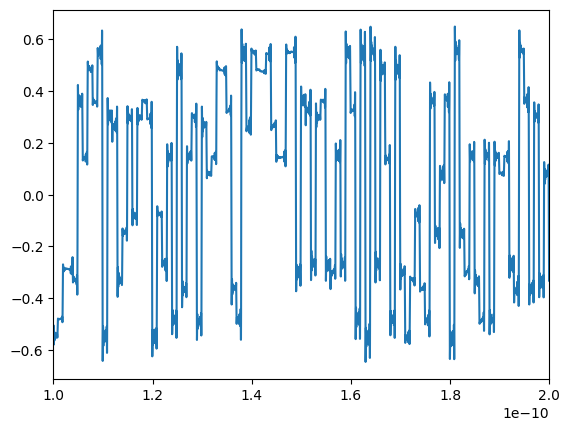

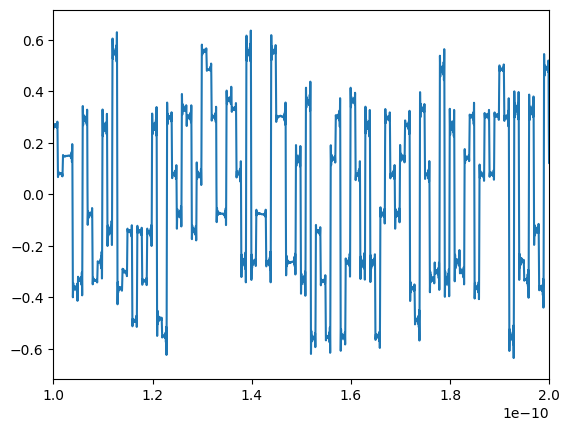

In [14]:
I = results.outputs["o1"].real
Q = results.outputs["o1"].imag
plt.plot(t,I)
plt.xlim(10e-11,20e-11)
plt.show()
plt.plot(t,Q)
plt.xlim(10e-11,20e-11)
plt.show()

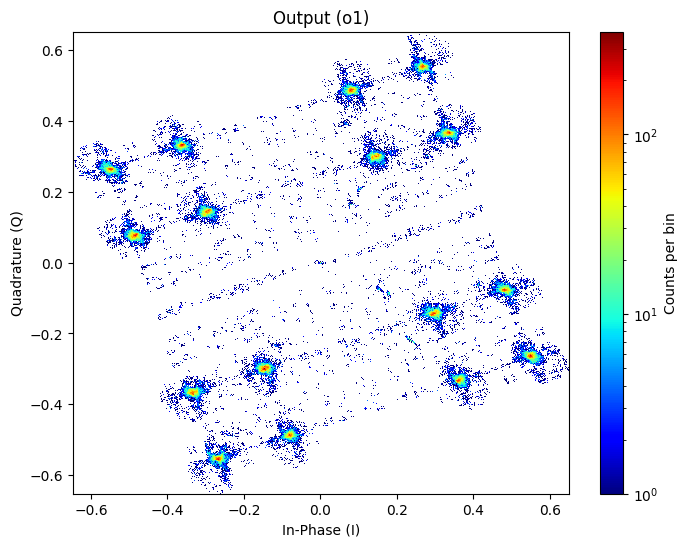

In [15]:
import matplotlib
def upsample_trajectory(I, Q, factor=20):
    I_list, Q_list = [], []
    n = len(I)
    for i in range(n - 1):
        i0, i1 = I[i], I[i+1]
        q0, q1 = Q[i], Q[i+1]
        for alpha in np.linspace(0, 1, factor, endpoint=False):
            I_list.append(i0 + alpha*(i1 - i0))
            Q_list.append(q0 + alpha*(q1 - q0))
    # Add the last point
    I_list.append(I[-1])
    Q_list.append(Q[-1])
    return np.array(I_list), np.array(Q_list)

# I_out_up, Q_out_up = upsample_trajectory(I, Q, factor=10)
plt.figure(figsize=(8,6))
bins = 500
plt.hist2d( I,Q, bins=bins, cmap='jet',norm=matplotlib.colors.LogNorm() )
plt.colorbar(label="Counts per bin")
plt.title("Output (o1)")
plt.xlabel("In-Phase (I)")
plt.ylabel("Quadrature (Q)")
plt.show()